# The task description


The following [dataset](https://github.com/PolyAI-LDN/task-specific-datasets/tree/master/banking_data) contains data about a customer service system in a US bank. The data set contains the customer request (txt) and the label - the category of the request.

You are asked to build a standard model that predicts this label. The task steps:



*   **Data exploration** - In this section, you will be asked to extract statistical information about the data. General Information about the dataset, and a plot about the distribution of the **meaningful** words in the dataset.



*   **Text Classification** - In this part, you are asked to fine-tune a pre-trained language model (search for an appropriate model from [Huginggface](https://huggingface.co/) ). After training the model you will be asked to evaluate the model results with 3 common metrics for the classification task.


**Make a plot on which we can calculate the metrics you chose above and many more.**





### *Notes*

- The colab offers free GPU usage up to a certain amount. Use it to train effectively.

- The most important thing here is self-learning ability, since you may encounter something you have not learned yet. It is not as important to achieve high-accuracy results as it is to understand what exactly you are doing.

# The notebook contains 3 main parts
 - ### Preprocessing
 - ### Data Exploration
 - ### Text Classification

# Preprocessing
##### 1. Download the task files from google drive
##### 2. Convert the data structures csv to DataFrame
##### 3. Convert labels categorical to numeric
##### 4. Convert the DataFrame to DatasetDict

In [ ]:
!pip install datasets
!pip install transformers
!pip install accelerate -U
!pip install evaluate

import requests
import pandas as pd
import json
from datasets import Dataset
from datasets import DatasetDict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.3 MB/s eta 0:00:00


### 1. Download the task files from google drive

In [ ]:
# download categories.json
response = requests.get('https://drive.google.com/uc?id=1TcTrEd3u0HVbwedY81PZl1HzUtWKUFtx')
with open('categories.json', 'wb') as file:
    file.write(response.content)

# download test.csv
response = requests.get('https://drive.google.com/uc?id=1j0uRDO02z2ymh5FPj-LmJ3_mbn_9T_yb')
with open('test.csv', 'wb') as file:
    file.write(response.content)

#download train.csv
response = requests.get('https://drive.google.com/uc?id=1DAgP-L0ipaWUF9dQSF0b-_FD0prENtNM&export=download')
with open('train.csv', 'wb') as file:
    file.write(response.content)

### 2. Convert the data structures csv to DataFrame

In [ ]:
trainDF = pd.read_csv('train.csv')
testDF = pd.read_csv('test.csv')

### 3. Convert labels categorical to numeric

In [ ]:
with open('/content/categories.json', 'r') as json_file:
    data = json.load(json_file)

label_mapping = {value: index for index, value in enumerate(data)}

def convert_labels_to_numeric(df, column_name):
    label_mapping = {label: i for i, label in enumerate(df[column_name].unique())}
    df[column_name] = df[column_name].map(label_mapping)
    return df

# Convert labels to numeric values
trainDFnumeric = convert_labels_to_numeric(trainDF.copy(), "category")
testDFnumeric = convert_labels_to_numeric(testDF.copy(), "category")
trainDFnumeric = trainDFnumeric.rename(columns={'category': 'label'})
testDFnumeric = testDFnumeric.rename(columns={'category': 'label'})

### 4. Convert the DataFrame to DatasetDict

In [ ]:
dataset_train = Dataset.from_pandas(trainDFnumeric)
dataset_test = Dataset.from_pandas(testDFnumeric)

dataset_dict = DatasetDict({"train": dataset_train, "test": dataset_test})
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})


# Data Exploration
*   Printing the first 10 records in the training file and in the test file
*   Printing the frequency of the categories in the training file and the test file
*   Performing tokenization and displaying word frequency
*   Showing word frequency after removing stop words




In [ ]:
import evaluate
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from transformers import AutoModelForSequenceClassification # Building a model
from transformers import AutoTokenizer, TrainingArguments, Trainer
from sklearn.metrics import precision_score, recall_score, f1_score

  ####  Printing the first 10 records in the training file and in the test file

In [ ]:
print("train")
print(trainDF.describe().head(1))
print(trainDF.head(10))
print("------------------------------------------------------------------ ")
print("------------------------------------------------------------------ ")
print("test")
print(testDF.describe().head(1))
print(testDF.head(10))

train
        text category
count  10003    10003
                                                text      category
0                     I am still waiting on my card?  card_arrival
1  What can I do if my card still hasn't arrived ...  card_arrival
2  I have been waiting over a week. Is the card s...  card_arrival
3  Can I track my card while it is in the process...  card_arrival
4  How do I know if I will get my card, or if it ...  card_arrival
5                  When did you send me my new card?  card_arrival
6       Do you have info about the card on delivery?  card_arrival
7  What do I do if I still have not received my n...  card_arrival
8       Does the package with my card have tracking?  card_arrival
9          I ordered my card but it still isn't here  card_arrival
------------------------------------------------------------------ 
------------------------------------------------------------------ 
test
       text category
count  3080     3080
                              

  ####  Printing the frequency of the categories in the training file and the test file

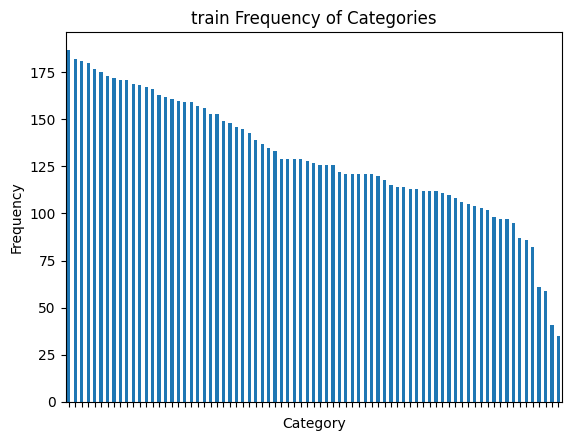

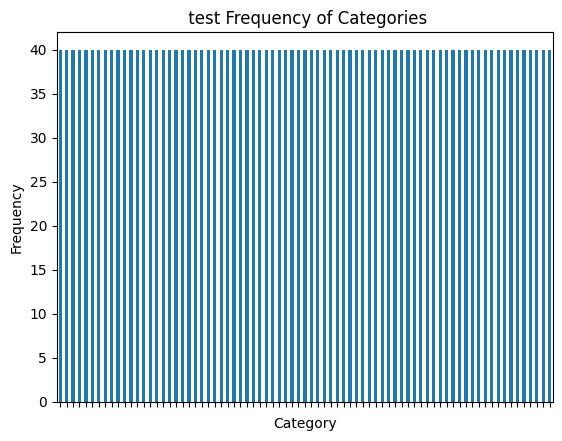

In [ ]:
category_counts = trainDF['category'].value_counts()

# Create a bar plot
ax = category_counts.plot(kind='bar')

plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('train Frequency of Categories')
# Hide the X axis tick labels
ax.set_xticklabels([])

plt.show()


# Count the frequency of each value in the "category" column
category_counts = testDF['category'].value_counts()

# Create a bar plot
ax = category_counts.plot(kind='bar')

# Set labels and title
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title(' test Frequency of Categories')
# Hide the X axis tick labels
ax.set_xticklabels([])

plt.show()

#### Performing tokenization and displaying word frequency

In [ ]:
nltk.download('punkt')

# Tokenize the text
tokens = [word for text in trainDF['text'] for word in word_tokenize(text)]

# Compute word frequencies
word_freq = FreqDist(tokens)

# Display the most common words
print(word_freq.most_common(20))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[('I', 8337), ('?', 6505), ('my', 5041), ('.', 4301), ('to', 4032), ('a', 3498), ('the', 3195), ('card', 2663), ('is', 2042), ('do', 1936), ('it', 1863), ("n't", 1581), (',', 1561), ('for', 1557), ('account', 1347), ('and', 1209), ('you', 1200), ('was', 1138), ('money', 1122), ('How', 1117)]


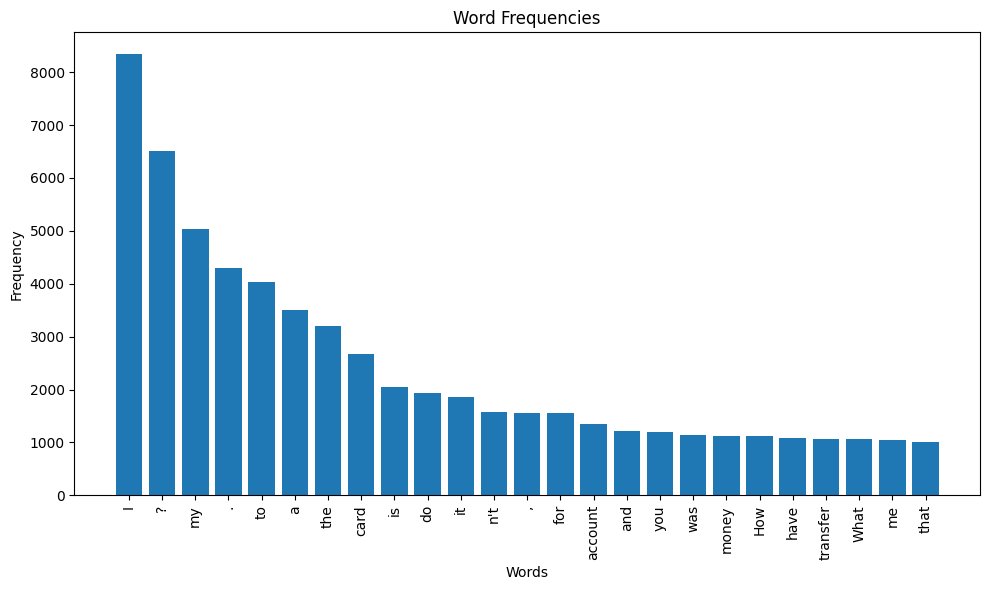

In [ ]:
# Get the words and frequencies from word_freq
words, frequencies = zip(*word_freq.most_common(25))

# Plot the word frequencies as a bar graph
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequencies')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

##### We see that there are many stop words like "my, to, a, the, do, is, it,for" so we remove them

#### Showing word frequency after removing stop words

In [ ]:
# Download the stopwords data
nltk.download('stopwords')

# Get the list of stop words
stop_words = set(stopwords.words('english'))

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def remove_stopwords(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]

    # Join the filtered tokens
    filtered_text = ' '.join(filtered_tokens)

    return filtered_text

def tokenize_function(examples):
    examples["text"] = [remove_stopwords(text) for text in examples["text"]]
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

# Tokenize the text
tokens = [word for text in tokenized_datasets["train"]['text'] for word in word_tokenize(text)]

# Compute word frequencies
word_freq = FreqDist(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Map:   0%|          | 0/10003 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

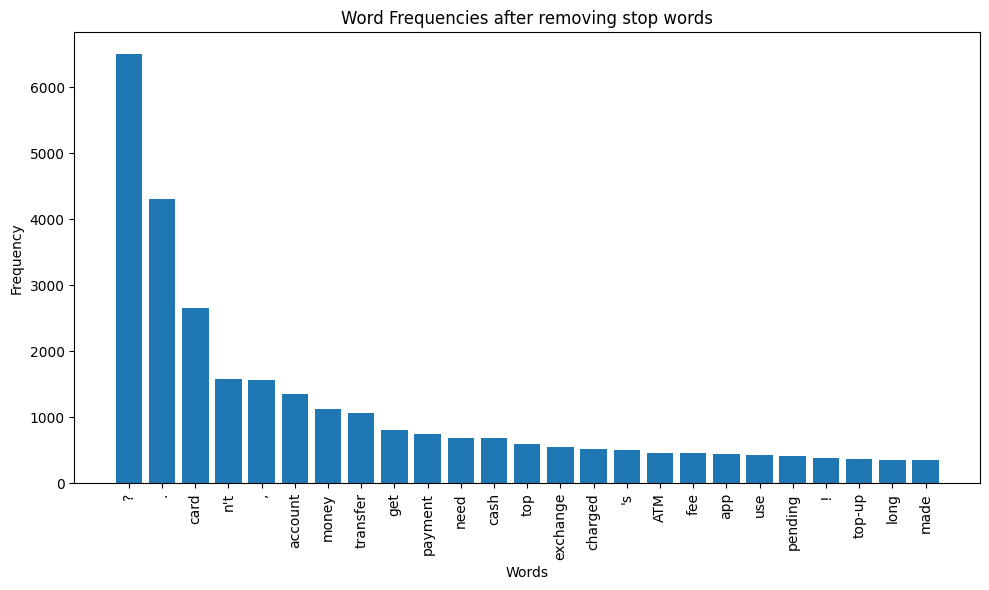

In [ ]:
# Get the words and frequencies from word_freq
words, frequencies = zip(*word_freq.most_common(25))

# Plot the word frequencies as a bar graph
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequencies after removing stop words')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Text Classification
### Prepare a dataset
##### 1. Tokenizer and remove stopwords
##### 2. Selection small data set (optional)
### Train with PyTorch Trainer (bert-base-cased model)
##### 1. Building a model
##### 2. Evaluate
##### 3. Training arguments
##### 4. Trainer (Fine-tune)
##### 5. Training summary from previous runs


## Prepare a dataset


### 1. Tokenizer and remove stopwords

In [ ]:
# Download the stopwords data
nltk.download('stopwords')

# Get the list of stop words
stop_words = set(stopwords.words('english'))

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def remove_stopwords(text):
    # Tokenize the text
    tokens = text.split()

    # Remove stop words
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]

    # Join the filtered tokens
    filtered_text = ' '.join(filtered_tokens)

    return filtered_text

def tokenize_and_remove_stopwords_function(examples):
    examples["text"] = [remove_stopwords(text) for text in examples["text"]]
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset_dict.map(tokenize_and_remove_stopwords_function, batched=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Map:   0%|          | 0/10003 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

### 2. Selection small data set (optional)

In [ ]:
select_small_data_set = False
if select_small_data_set:
  small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
  small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))
else:
  small_train_dataset = tokenized_datasets["train"]
  small_eval_dataset = tokenized_datasets["test"]

print(small_train_dataset)
print(small_eval_dataset)

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 10003
})
Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3080
})


## Train with PyTorch Trainer


### 1. Building a model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=77)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 2. Evaluate

In [ ]:
metric_accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = metric_accuracy.compute(predictions=predictions, references=labels)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

### 3. Training arguments

In [ ]:
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

### 4. Trainer (Fine-tune)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.298000,0.720285,{'accuracy': 0.8243506493506494},0.842432,0.824351,0.813481
2,0.431300,0.460247,{'accuracy': 0.8766233766233766},0.890836,0.876623,0.873154
3,0.215700,0.417365,{'accuracy': 0.8954545454545455},0.899796,0.895455,0.895130


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'accuracy': 0.8243506493506494}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8766233766233766}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8954545454545455}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


TrainOutput(global_step=3753, training_loss=0.8903045623803691, metrics={'train_runtime': 3068.0603, 'train_samples_per_second': 9.781, 'train_steps_per_second': 1.223, 'total_flos': 7901016582896640.0, 'train_loss': 0.8903045623803691, 'epoch': 3.0})

### 5. Training summary from previous runs

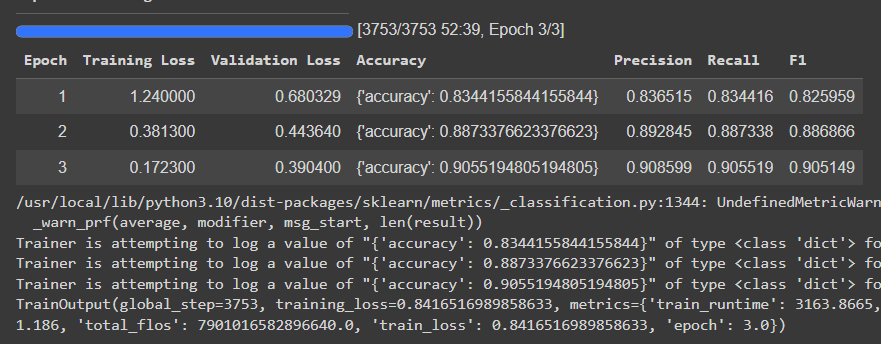